## TODOs
- TODO: Need to drop `PurchaseWhat` for these regressions

In [32]:
import analyze
import prep
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import altair as alt
from altair_saver import save
%load_ext rpy2.ipython

%load_ext autoreload
%autoreload 2

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_PATH = "../data/2020/survey_results_public.csv"
data_raw = pd.read_csv(DATA_PATH)
outcome = "DevType"
data_2020, keep, groups, categorical, numeric, base = prep.prep(data_raw, outcome, 2020)

DATA_PATH = "../data/2019/survey_results_public.csv"
data_raw = pd.read_csv(DATA_PATH)
data_2019, keep, groups, categorical, numeric, base = prep.prep(data_raw, outcome, 2019)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Removing 26 respondents with missing DevType
6258 developers left in the sample after cleaning
151 or 2.4% black developers in the sample with multiracial replacement
Removing 87 respondents with missing DevType
12415 developers left in the sample after cleaning
288 or 2.3% black developers in the sample with multiracial replacement


In [3]:
data = pd.concat([data_2020, data_2019], axis=0)

In [4]:
data["Leader"] = data["DevType"].str.split(";").map(lambda x: ("Engineering manager" in x) | ("Senior executive/VP" in x))
data = data.drop(["DevType"], axis=1)

In [5]:
data["Leader"].value_counts() / len(data)

False    0.915654
True     0.084346
Name: Leader, dtype: float64

In [6]:
outcome = "Leader"
X, Y = prep.design_matrix(data, categorical, numeric, base, outcome)
X = X.drop([col for col in X.columns if "PurchaseWhat" in col], axis=1)

Design matrix complete with 159 variables/columns


In [26]:
data["Ethnicity_Black_or_of_African_descent"] = data["Ethnicity"] == "Black or of African descent"

In [27]:
breakdown = ["Leader"]

In [81]:
labels = ["Non-Black", "Black"]
colors = ["#fa7026", "#612b8a"]

In [31]:
representation = {}

representation["Leader"] = pd.DataFrame({"labels": labels, 
                                         "data": data.groupby("Ethnicity_Black_or_of_African_descent").mean()["Leader"].values})

In [113]:
color_scale = alt.Scale(
    domain=labels,
    range=colors
)

points = alt.Chart().mark_bar(size=180, cornerRadiusBottomRight=18, cornerRadiusTopRight=18, clip=True, color="#612b8a").encode(
    x=alt.X("data", 
            axis=alt.Axis(format=".1%", title=None, tickCount=5, tickSize=0, labelFlush=False, labelFontSize=15),
    ),
    y=alt.Y("labels", 
            axis=alt.Axis(title=None, labelFontSize=15), sort="-x"
           ),
    color=alt.Color("labels", 
                    scale=color_scale,
                    legend=None)
)

text = alt.Chart().mark_text(
    align='left',
    baseline='middle',
    dx=10,
    dy=0,
    fontSize=15
).encode(
    text=alt.Text("data", format=".1%"),
    x="data",
    y=alt.Y("labels", sort="-x"),
)

chart = alt.layer(points, text, data=representation["Leader"]).properties(
    width=600,
    height=500,
    title={
        "text": "Engineering Managers and Executives By Race", 
        "subtitle": "% of Software Developers",
        "subtitleColor": "gray"
    }
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    offset=5,
    fontSize=20
).configure_axis(
    domain=False
)

chart.save("progression_leaders.png", method="selenium", webdriver="chrome", scale_factor=3.0)

chart

alt.LayerChart(...)

In [7]:
D = "Ethnicity"
results = analyze.analyze(Y, X, D)
results

,coef_ds,se_ds,t_ds,p_ds,lower_ds,upper_ds,coef_raw,se_raw,t_raw,p_raw,lower_raw,upper_raw
Ethnicity_Black_or_of_African_descent,-0.001633,0.01291,-0.126463,0.899365,-0.026936,0.023671,-0.016404,0.013423,-1.222067,0.221698,-0.042714,0.009907


In [8]:
D = "Ethnicity"
results = analyze.analyze(Y, X, D, logit=True)
results

Optimization terminated successfully.
         Current function value: 0.289215
         Iterations 7


,coef_ds,se_ds,t_ds,p_ds,lower_ds,upper_ds,coef_raw,se_raw,t_raw,p_raw,lower_raw,upper_raw
Ethnicity_Black_or_of_African_descent,-0.038762,0.197865,-0.1959,0.844688,-0.426595,0.349071,-0.232911,0.191013,-1.21935,0.222711,-0.607289,0.141467


In [138]:
from glmnet import LogitNet

In [145]:
model = LogitNet().fit(X=X.drop([col for col in X.columns if D in col], axis=1).assign(const=1), 
                       y=Y)

predictions = pd.Series(model.predict_proba(X=X.drop([col for col in X.columns if D in col], axis=1).assign(const=1))[:,1])

Exception: Data must be 1-dimensional

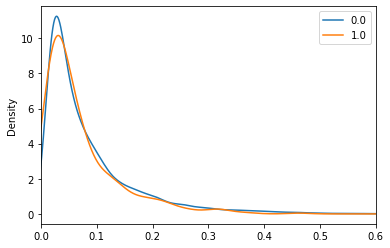

In [158]:
pd.concat([X.reset_index(drop=True), predictions.rename("preds")], axis=1).groupby("Ethnicity_Black_or_of_African_descent")["preds"].plot.kde()
plt.legend()
plt.xlim(0,0.6)
plt.show()

In [159]:
X_q = {}
Y_q = {}
quantiles = 5

for q in range(1, quantiles+1):
    X_q[q] = X.reset_index(drop=True).loc[(predictions <= predictions.quantile(q/quantiles)) & (predictions > predictions.quantile(q/quantiles-(1/quantiles)))]
    Y_q[q] = Y.reset_index(drop=True).loc[(predictions <= predictions.quantile(q/quantiles)) & (predictions > predictions.quantile(q/quantiles-(1/quantiles)))]

In [160]:
results_q_plot = (pd.concat([pd.concat([(pd.concat([Y_q[q], X_q[q]], axis=1)
                         .groupby(["Ethnicity_Black_or_of_African_descent"])
                         .mean()["Leader"]), 
                       pd.Series([q]* 2, name="quantile"),
                       pd.Series(labels, name="labels")], 
                     axis=1) for q in range(1, quantiles+1)])
                  .reset_index(drop=True)
                  .rename(columns={"Leader": "data"}))

In [161]:
results_q_plot

,data,quantile,labels
0,0.007438,1,Non-Black
1,0.000000,1,Black
2,0.020914,2,Non-Black
3,0.020000,2,Black
4,0.052155,3,Non-Black
5,0.032609,3,Black
6,0.098661,4,Non-Black
7,0.080000,4,Black
8,0.242978,5,Non-Black
9,0.279412,5,Black


In [162]:
color_scale = alt.Scale(
    domain=labels,
    range=colors
)

points = alt.Chart().mark_bar(size=35, cornerRadiusTopLeft=8, cornerRadiusTopRight=8, clip=True).encode(
    x=alt.X("labels", 
        axis=alt.Axis(title=None, labels=False, tickSize=0), 
        sort=labels
       ),
    y=alt.Y("data", 
            axis=alt.Axis(format=".1%", title=None, tickCount=4, tickSize=0, labelFlush=False, labelFontSize=15),
    ),
    color=alt.Color("labels", 
                    scale=color_scale,
                    legend=alt.Legend(title=None, orient="bottom", labelFontSize=15))
).properties(
    width=100,
    height=300
)

text = alt.Chart().mark_text(
    align='center',
    baseline='middle',
    dx=0,
    dy=-20,
    fontSize=15
).encode(
    text=alt.Text("data", format=".1%"),
    x=alt.X("labels", 
            sort=labels),
    y="data",
    color=alt.Color("labels", 
                    scale=color_scale)
)

chart = alt.layer(points, text, data=results_q_plot).facet(
    column=alt.Column("quantile", title=None, header=alt.Header(labelOrient='bottom', labelFontSize=15)),
    title={
        "text": "Engineering Managers or Executives by Leadership Score Quintile", 
        "subtitle": "% of Software Developers",
        "subtitleColor": "gray",
    },
    spacing=10
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    offset=5,
    fontSize=20
).configure_axis(
    domain=False
)

chart.save("progression_leaders_quintile.png", method="selenium", webdriver="chrome", scale_factor=3.0)

chart

alt.FacetChart(...)

In [13]:
model = sm.Logit(endog=Y, exog=X.drop([col for col in X.columns if D in col], axis=1).assign(const=1)).fit()
predictions = pd.Series(model.predict())

Optimization terminated successfully.
         Current function value: 0.231134
         Iterations 9


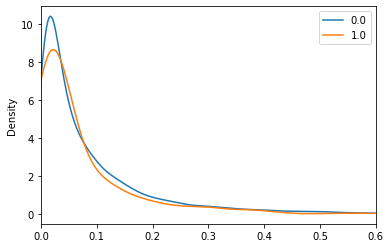

In [122]:
pd.concat([X.reset_index(drop=True), predictions.rename("preds")], axis=1).groupby("Ethnicity_Black_or_of_African_descent")["preds"].plot.kde()
plt.legend()
plt.xlim(0,0.6)
plt.show()

In [ ]:
X_q = {}
Y_q = {}
quantiles = 5

for q in range(1, quantiles+1):
    X_q[q] = X.reset_index(drop=True).loc[(predictions <= predictions.quantile(q/quantiles)) & (predictions > predictions.quantile(q/quantiles-(1/quantiles)))]
    Y_q[q] = Y.reset_index(drop=True).loc[(predictions <= predictions.quantile(q/quantiles)) & (predictions > predictions.quantile(q/quantiles-(1/quantiles)))]

In [82]:
results_q_plot = (pd.concat([pd.concat([(pd.concat([Y_q[q], X_q[q]], axis=1)
                         .groupby(["Ethnicity_Black_or_of_African_descent"])
                         .mean()["Leader"]), 
                       pd.Series([q]* 2, name="quantile"),
                       pd.Series(labels, name="labels")], 
                     axis=1) for q in range(1, quantiles+1)])
                  .reset_index(drop=True)
                  .rename(columns={"Leader": "data"}))

In [84]:
results_q_plot

,data,quantile,labels
0,0.004971,1,Non-Black
1,0.000000,1,Black
2,0.019257,2,Non-Black
3,0.010101,2,Black
4,0.045392,3,Non-Black
5,0.040000,3,Black
6,0.097249,4,Non-Black
7,0.111111,4,Black
8,0.254699,5,Non-Black
9,0.281250,5,Black


In [129]:
color_scale = alt.Scale(
    domain=labels,
    range=colors
)

points = alt.Chart().mark_bar(size=35, cornerRadiusTopLeft=8, cornerRadiusTopRight=8, clip=True).encode(
    x=alt.X("labels", 
        axis=alt.Axis(title=None, labels=False, tickSize=0), 
        sort=labels
       ),
    y=alt.Y("data", 
            axis=alt.Axis(format=".1%", title=None, tickCount=4, tickSize=0, labelFlush=False, labelFontSize=15),
    ),
    color=alt.Color("labels", 
                    scale=color_scale,
                    legend=alt.Legend(title=None, orient="bottom", labelFontSize=15))
).properties(
    width=100,
    height=300
)

text = alt.Chart().mark_text(
    align='center',
    baseline='middle',
    dx=0,
    dy=-20,
    fontSize=15
).encode(
    text=alt.Text("data", format=".1%"),
    x=alt.X("labels", 
            sort=labels),
    y="data",
    color=alt.Color("labels", 
                    scale=color_scale)
)

chart = alt.layer(points, text, data=results_q_plot).facet(
    column=alt.Column("quantile", title=None, header=alt.Header(labelOrient='bottom', labelFontSize=15)),
    title={
        "text": "Engineering Managers or Executives by Leadership Score Quintile", 
        "subtitle": "% of Software Developers",
        "subtitleColor": "gray",
    },
    spacing=10
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    offset=5,
    fontSize=20
).configure_axis(
    domain=False
)

chart.save("progression_leaders_quintile.png", method="selenium", webdriver="chrome", scale_factor=3.0)

chart

alt.FacetChart(...)

In [15]:
D = "Ethnicity"
start_q = 2
results_q = []
for q in range(start_q, quantiles+1):
    print(q)
    results_q.append(analyze.analyze(Y_q[q], X_q[q], D, logit=True))
    
results_q = pd.concat(results_q, axis=0)
results_q.index = range(start_q, quantiles+1)

2
Optimization terminated successfully.
         Current function value: 0.094068
         Iterations 9
3
Optimization terminated successfully.
         Current function value: 0.184241
         Iterations 7
4
Optimization terminated successfully.
         Current function value: 0.319268
         Iterations 6
5
Optimization terminated successfully.
         Current function value: 0.567865
         Iterations 5


In [17]:
results_q

,coef_ds,se_ds,t_ds,p_ds,lower_ds,upper_ds,coef_raw,se_raw,t_raw,p_raw,lower_raw,upper_raw
2,-0.652879,1.032939,-0.632060,0.527348,-2.678059,1.372300,-0.659297,1.012366,-0.651244,0.514889,-2.643497,1.324904
3,-0.124737,0.518825,-0.240422,0.810003,-1.141944,0.892471,-0.132200,0.516506,-0.255951,0.797989,-1.144533,0.880133
4,0.106196,0.404783,0.262353,0.793049,-0.687422,0.899814,0.139011,0.404923,0.343302,0.731371,-0.654624,0.932646
5,0.144263,0.283571,0.508736,0.610937,-0.411707,0.700233,0.137429,0.280628,0.489717,0.624334,-0.412593,0.687450


In [18]:
results_q_plot = pd.melt(results_q.reset_index()[["index", "coef_ds", "coef_raw"]], id_vars=["index"]).rename(columns={"value": "data", "variable": "labels"})

In [20]:
results_q_plot["lower"] = np.exp(pd.melt(results_q.reset_index()[["index", "lower_ds", "lower_raw"]], id_vars=["index"])["value"])
results_q_plot["upper"] = np.exp(pd.melt(results_q.reset_index()[["index", "upper_ds", "upper_raw"]], id_vars=["index"])["value"])
results_q_plot["data"] = np.exp(results_q_plot["data"])

In [22]:
results_q_plot.loc[results_q_plot["labels"] == "coef_ds", "labels"] = "Black (Adj.)"
results_q_plot.loc[results_q_plot["labels"] == "coef_raw", "labels"] = "Black (Raw)"

In [24]:
results_q_plot = pd.concat([results_q_plot, pd.DataFrame({"index": range(2, quantiles+1), "labels": "Non-Black", "data": 1.0})])

In [25]:
results_q_plot

,index,labels,data,lower,upper
0,2,Black (Adj.),0.520545,0.068696,3.944412
1,3,Black (Adj.),0.882729,0.319198,2.441154
2,4,Black (Adj.),1.112040,0.502871,2.459145
3,5,Black (Adj.),1.155188,0.662519,2.014221
4,2,Black (Raw),0.517215,0.071112,3.761823
5,3,Black (Raw),0.876166,0.318373,2.411219
6,4,Black (Raw),1.149137,0.519637,2.541224
7,5,Black (Raw),1.147320,0.661932,1.988638
0,2,Non-Black,1.000000,NaN,NaN
1,3,Non-Black,1.000000,NaN,NaN
